In [172]:
import sys
import numpy as np
import random
import pickle
import os
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import json
%matplotlib inline

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

import models

sys.path.append("../../../FedLab/")

from fedlab.utils.dataset import functional as dataF
from fedlab.utils import SerializationTool
from fedlab.utils.functional import save_dict, load_dict

In [46]:
from fedlab.utils.dataset import CIFAR100Partitioner

In [88]:
params1 = SerializationTool.serialize_model(model)
params2 = SerializationTool.serialize_model(model)
params3 = params1.data
params4 = params1

print(params1)
print(params2)
print(params3)


tensor([-0.0535,  0.0145,  0.0168,  ..., -0.0213,  0.0006,  0.0269])
tensor([-0.0535,  0.0145,  0.0168,  ..., -0.0213,  0.0006,  0.0269])
tensor([-0.0535,  0.0145,  0.0168,  ..., -0.0213,  0.0006,  0.0269])


In [98]:
params1 is params2, params1 is params3, params1 is params4, params1.data is params3

(False, False, True, False)

In [97]:
print(type(params1), params1.requires_grad)
print(type(params2), params2.requires_grad)
print(type(params3), params3.requires_grad)
print(type(params4), params4.requires_grad)

<class 'torch.Tensor'> False
<class 'torch.Tensor'> False
<class 'torch.Tensor'> False
<class 'torch.Tensor'> False


In [182]:
def str2list(str):
    lis = str[1:-1].split(',')
    res = []
    for i, ele in enumerate(lis):
        if len(lis[i]) > 0:
            res.append(float(ele))
    
    return res

def result_file_parser(file_name):
    res = dict()
    with open(file_name) as f:
        for line in f.readlines():
            line = line.strip()
            if line[0]=='{':
                line = line.replace("\'", "\"")
                res['setting'] = json.loads(line)
            else:
                line = line.split(':')
                key_name, value_str = line[0], line[1]
                values = str2list(value_str)
                if len(values)>0:
                    res[key_name] = values
    return res

In [268]:
res_files = [file for file in os.listdir("./Output/") if file[:7] in ['FedDyn_', 'FedAvg_']]
all_res = dict()
for fn in res_files:
    all_res[fn] = result_file_parser(os.path.join('./Output/', fn))

feddyn_file = [file for file in res_files if file[:7]=='FedDyn_'][0]
fedavg_file = [file for file in res_files if file[:7]=='FedAvg_'][0]

feddyn_res = all_res[feddyn_file]
fedavg_res = all_res[fedavg_file]

In [230]:
feddyn_feddyn_res = torch.load('./Output/feddyn-FedDyn_metrics.pkl')
feddyn_fedavg_res = torch.load('./Output/feddyn-FedAvg_metrics.pkl')

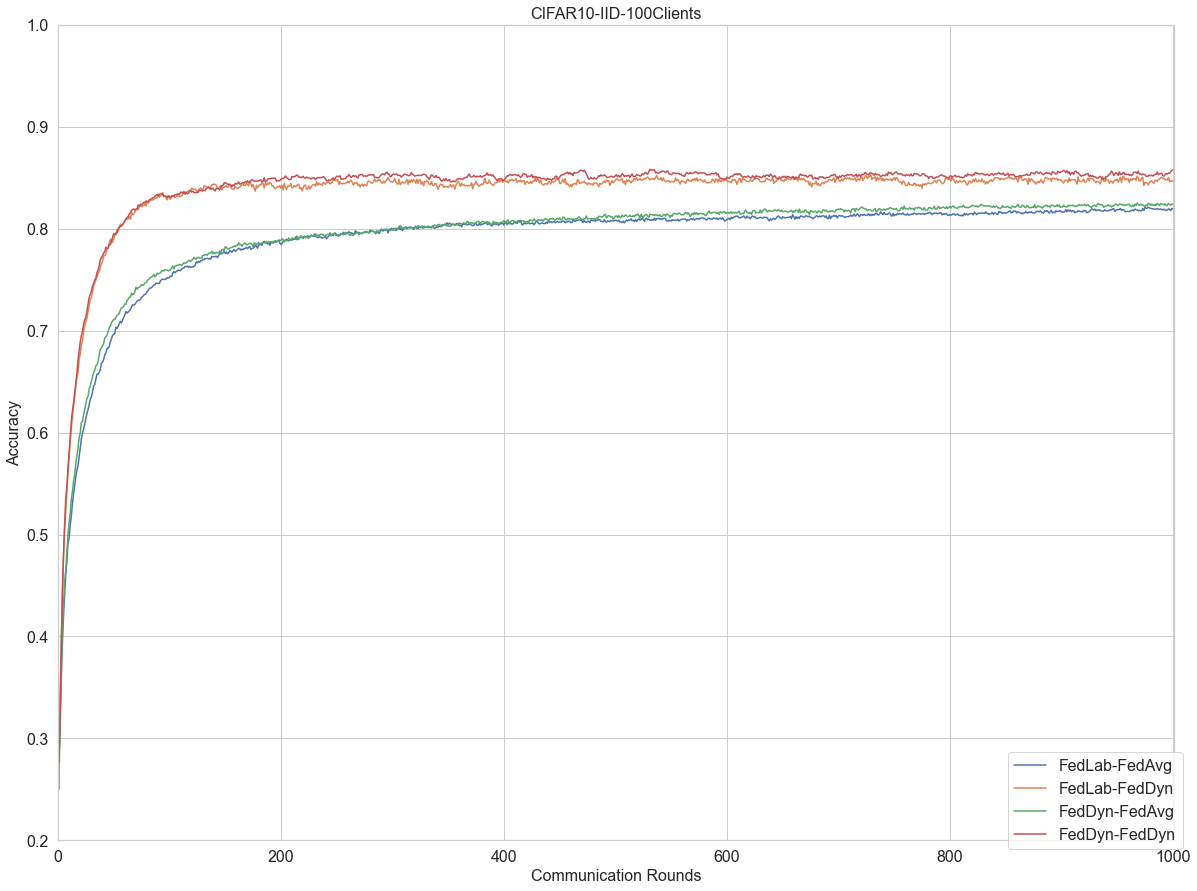

In [273]:
plt.figure(figsize=(20, 15))
plt.plot(np.arange(len(fedavg_res['acc']))+1, fedavg_res['acc'], label='FedLab-FedAvg')
plt.plot(np.arange(len(feddyn_res['cld_mdl_test_acc']))+1, feddyn_res['cld_mdl_test_acc'], label='FedLab-FedDyn')
plt.plot(np.arange(1000)+1, feddyn_fedavg_res['tst_perf_sel_FedAvg'][:,1], label='FedDyn-FedAvg')
plt.plot(np.arange(1000)+1, feddyn_feddyn_res['tst_perf_sel_FedDyn'][:,1], label='FedDyn-FedDyn')
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Communication Rounds', fontsize=16)
plt.legend(fontsize=16, loc='lower right', bbox_to_anchor=(1.015, -0.02))
plt.xlim([0, len(fedavg_res['acc'])+1])
plt.ylim([0.2, 1.0])
plt.title('CIFAR10-IID-100Clients', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(np.arange(0.2, 1.05, step=0.1),fontsize=16)
plt.grid(True)
plt.savefig('./Output/CIFAR10_100_iid_plots.png', dpi=1000, bbox_inches='tight')
# plt.show() 

In [267]:
acc1 = 0.814
acc2 = 0.85
paper_acc1_round = 67
paper_acc2_round = 198
feddyn_feddyn_acc1_round = np.argwhere(feddyn_feddyn_res['tst_perf_sel_FedDyn'][:,1]>=acc1)[0,0] + 1
feddyn_feddyn_acc2_round = np.argwhere(feddyn_feddyn_res['tst_perf_sel_FedDyn'][:,1]>=acc2)[0,0] + 1
fedlab_feddyn_acc1_round = np.argwhere(np.array(feddyn_res['cld_mdl_test_acc'])>=acc1)[0,0] + 1
fedlab_feddyn_acc2_round = np.argwhere(np.array(feddyn_res['cld_mdl_test_acc'])>=acc2)[0,0] + 1

print("                         Paper   FedDyn   FedLab")
print(f"Round for acc>{acc1*100:.2f}%: {paper_acc1_round:8d},{feddyn_feddyn_acc1_round:8d},{fedlab_feddyn_acc1_round:8d}")  
print(f"Round for acc>{acc2*100:.2f}%: {paper_acc2_round:8d},{feddyn_feddyn_acc2_round:8d},{fedlab_feddyn_acc2_round:8d}")

                         Paper   FedDyn   FedLab
Round for acc>81.40%:       67,      64,      66
Round for acc>85.00%:      198,     185,     296


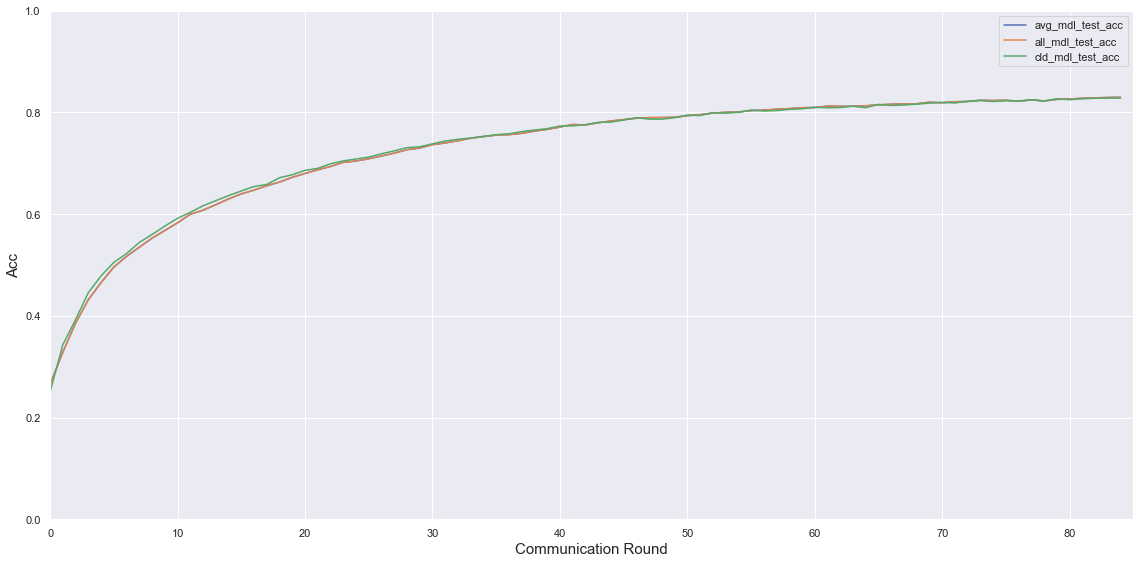

In [190]:
# all_res = dict()
# for fn in res_files:
#     all_res[fn] = result_file_parser(os.path.join('./Output/', fn))

# round_num = len(all_res[res_files[0]]['all_mdl_test_acc'])
# round_col = list(range(round_num))
# content = {key:all_res[res_files[0]][key] for key in all_res[res_files[0]] if key!='setting'}
# content['Round'] = round_col

# res_df = pd.DataFrame(content)
# res_df['Round'] = res_df['Round'].astype(int)
# # res_df = res_df.set_index('Round')
# col_names = list(res_df.columns)

# colors = ["#FF0B04", "#4374B3"]# Set your custom color palette
# xy_fz = 15
# title_fz = 20

# sns.set_palette(sns.color_palette(colors))
# sns.set_theme(style="ticks")
# sns.set_style("darkgrid")
# fig = plt.figure(figsize=(16, 8))  # create a figure object
# ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
# # plt.figure(figsize=(16, 8))
# plt.ylim([0, 1])
# plt.xlim([0,round_num])

# res_df.plot(x='Round', y=[key for key in col_names if key[-3:]=='acc'], grid=True, ax=ax)
# plt.xlabel('Communication Round',fontsize=xy_fz)
# plt.ylabel('Acc',fontsize=xy_fz)
# # plt.xticks(list(range(round_num)))
# plt.tight_layout()
# plt.savefig("./Output/feddyn-cifar10-acc.png",dpi=700)

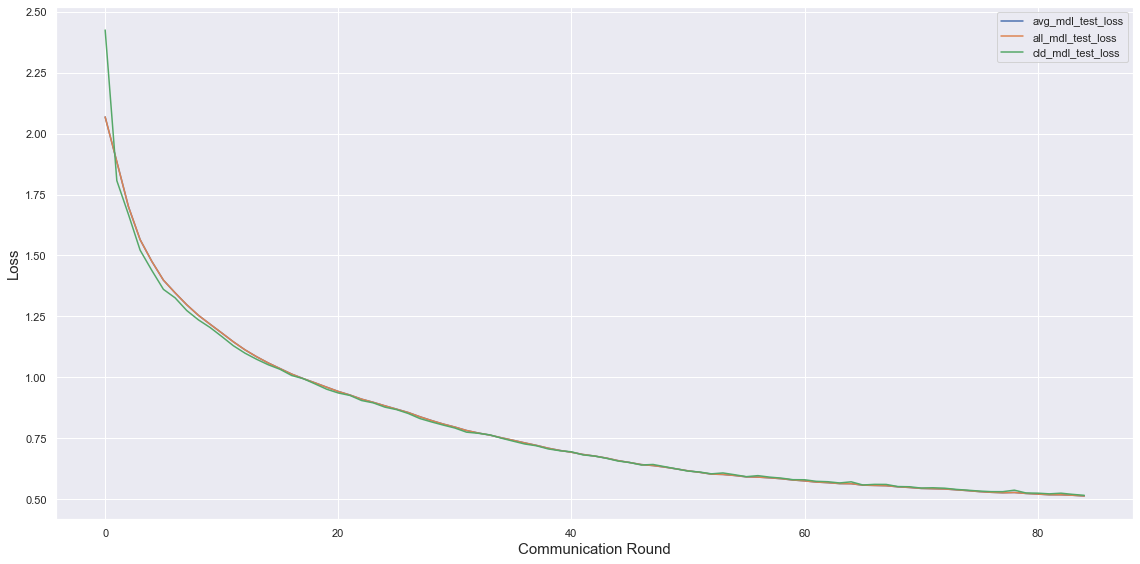

In [191]:
# colors = ["#FF0B04", "#4374B3"]# Set your custom color palette
# xy_fz = 15
# title_fz = 20

# sns.set_palette(sns.color_palette(colors))
# sns.set_theme(style="ticks")
# sns.set_style("darkgrid")
# fig = plt.figure(figsize=(16, 8))  # create a figure object
# ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
# # plt.figure(figsize=(16, 8))
# # plt.ylim([0, 1])

# res_df.plot(x='Round', y=[key for key in col_names if key[-4:]=='loss'], grid=True, ax=ax)
# plt.xlabel('Communication Round',fontsize=xy_fz)
# plt.ylabel('Loss',fontsize=xy_fz)
# # plt.xticks(list(range(round_num)))
# plt.tight_layout()
# # plt.savefig("./imgs/cifar10-feddyn-acc.png",dpi=400)

In [166]:
from datetime import datetime

In [171]:
date_time_str_start = '2021-10-23 23:54:49'
date_time_str_end = '2021-10-24 2:35:43'

date_time_start = datetime.strptime(date_time_str_start, '%Y-%m-%d %H:%M:%S')
date_time_end = datetime.strptime(date_time_str_end, '%Y-%m-%d %H:%M:%S')

print((date_time_end - date_time_start).total_seconds() / 60.0)

print ("The type of the date is now",  type(date_time_start))
print ("The date is", date_time_start)

160.9
The type of the date is now <class 'datetime.datetime'>
The date is 2021-10-23 23:54:49
